## Предсказание стоимости жилья

В проекте вам нужно обучить модель линейной регрессии на данных о жилье в Калифорнии в 1990 году. На основе данных нужно предсказать медианную стоимость дома в жилом массиве. Обучите модель и сделайте предсказания на тестовой выборке. Для оценки качества модели используйте метрики RMSE, MAE и R2.


 
Основная задача проекта заключается в обучении модели линейной регрессии на данных о жилье в Калифорнии в 1990 году для предсказания медианной стоимости дома. В колонках датасета содержатся следующие данные:

longitude — широта;
latitude — долгота;
housing_median_age — медианный возраст домов в жилом массиве;
total_rooms — общее количество комнат в домах жилого массива;
total_bedrooms — общее количество спален в домах жилого массива;
population — количество человек, которые проживают в жилом массиве;
households — количество домовладений в жилом массиве;
median_income — медианный доход жителей жилого массива;
median_house_value — медианная стоимость дома в жилом массиве;
ocean_proximity — близость к океану.

 **Цель исследования**
 
Цель проекта заключается в анализе данных о жилье в Калифорнии в 1990 году, а именно:
1. Проанализировать основную информацию о жилье.
2. Провести предобработку и подготовку данных.
3. Провести обучение моделей на всех признаках и на только на числовых признаках.
4. Проверить качество моделей по метрикам RMSE, MAE и R2.

**Ход исследования**

Данные для исследования получены из одного датафрейма. В  данных есть информация о координатах жилья, его основных параметрах и данные о жильцах. 

Таким образом, исследование будет состоять из следующих этапов:
- обзор данных;
- предобработка данных (при необходимости);
- исследование моделей линейной регрессии на всех признаках и на только на числовых признаках;
- сравнение качества моделей по метрикам RMSE, MAE и R2;
- основные выводы.

# Подготовка данных

Подключение библиотек, инициализация Spark-сессии.

In [1]:
import pandas as pd 
import numpy as np

import seaborn as sns

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

RANDOM_SEED = 42
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
spark = SparkSession.builder \
                    .master("local") \
                    .appName("California Housing") \
                    .getOrCreate()

Загрузка данных.

In [3]:
df_housing = spark.read.load('/datasets/housing.csv',
                                        format='csv',
                                             sep=',',
                                    inferSchema=True,
                                         header=True)

#вывод схемы датафрейма
df_housing.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



Вывод типов данных колонок и их названий.

In [4]:
print(pd.DataFrame(df_housing.dtypes, columns=['column', 'type']))

               column    type
0           longitude  double
1            latitude  double
2  housing_median_age  double
3         total_rooms  double
4      total_bedrooms  double
5          population  double
6          households  double
7       median_income  double
8  median_house_value  double
9     ocean_proximity  string


# Анализ данных

Вывод первых строк датафрейма.

In [5]:
pd.DataFrame(df_housing.take(5), columns=df_housing.columns)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.230,37.880,41.000,880.000,129.000,322.000,126.000,8.325,452600.000,NEAR BAY
1,-122.220,37.860,21.000,7099.000,1106.000,2401.000,1138.000,8.301,358500.000,NEAR BAY
2,-122.240,37.850,52.000,1467.000,190.000,496.000,177.000,7.257,352100.000,NEAR BAY
3,-122.250,37.850,52.000,1274.000,235.000,558.000,219.000,5.643,341300.000,NEAR BAY
4,-122.250,37.850,52.000,1627.000,280.000,565.000,259.000,3.846,342200.000,NEAR BAY


Просмотрим значения, содержащиеся в категориальной переменной.

In [6]:
df_housing.groupBy('ocean_proximity').count().toPandas()

,ocean_proximity,count
0,ISLAND,5
1,NEAR OCEAN,2658
2,NEAR BAY,2290
3,<1H OCEAN,9136
4,INLAND,6551


Посмотрим описательную статистику числовых данных.

In [7]:
df_housing.describe().toPandas()

,summary,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,count,20640,20640,20640,20640,20433,20640,20640,20640,20640,20640
1,mean,-119.56970445736148,35.6318614341087,28.639486434108527,2635.7630813953488,537.8705525375618,1425.4767441860465,499.5396802325581,3.8706710029070246,206855.81690891474,None
2,stddev,2.003531723502584,2.135952397457101,12.58555761211163,2181.6152515827944,421.38507007403115,1132.46212176534,382.3297528316098,1.899821717945263,115395.61587441359,None
3,min,-124.35,32.54,1.0,2.0,1.0,3.0,1.0,0.4999,14999.0,<1H OCEAN
4,max,-114.31,41.95,52.0,39320.0,6445.0,35682.0,6082.0,15.0001,500001.0,NEAR OCEAN


Исследуем данные на наличие пропусков.

In [8]:
columns = df_housing.columns


for column in columns:
    print(column, df_housing.where(F.isnan(column) | F.col(column).isNull()).count())

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 207
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


Пропуски есть в колонке total_bedrooms. Так как по условиям задачи необходимо использовать линейную регрессию, то пропуски следует заполнить. Так как пропусков всего примерно один процент (207 из 20433), то заполним такие значения медианным значением признака.

Получим медианное значение и выведем его на экран.

In [9]:
total_bedrooms_median = df_housing.approxQuantile('total_bedrooms', [0.5], 0)[0]

total_bedrooms_median

435.0

Заполним пропущенные значения.

In [10]:
df_housing = df_housing.fillna(total_bedrooms_median, subset=['total_bedrooms'])
df_housing.select(
    [F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df_housing.columns]
    ).toPandas().T.rename(columns={0:'NA'})

,NA
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,0
population,0
households,0
median_income,0
median_house_value,0
ocean_proximity,0


Рассмотрим корреляцию признаков, исключив целевой и категориальный признаки.

Выделим признаки.

In [11]:
num_columns = [c for c in df_housing.columns if c != 'ocean_proximity']

24/02/02 16:03:49 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
24/02/02 16:03:49 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


<AxesSubplot:>

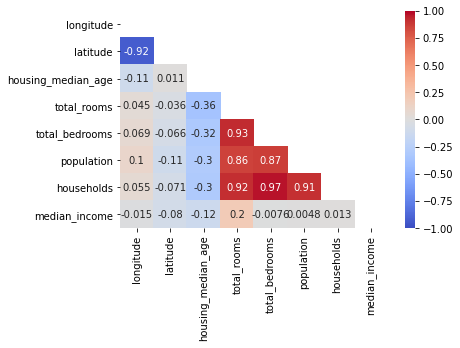

In [12]:

corr_columns = [c for c in num_columns if c != 'median_house_value']
num_columns = [c for c in df_housing.columns if c != 'ocean_proximity']
#преобразуем данные в `Vector`
vector_col = 'corr_features'
assembler = VectorAssembler(inputCols=corr_columns, outputCol=vector_col)
df_vector = assembler.setHandleInvalid("skip").transform(df_housing[corr_columns]).select(vector_col)

#создаем матрицу
matrix = Correlation.corr(df_vector, vector_col)
cor_np = matrix.collect()[0][matrix.columns[0]].toArray()


matrix_df = pd.DataFrame(cor_np, columns=corr_columns)
matrix_df.index = corr_columns

#делаем "уголок" и выводим график корреляции в виде heatmap
matrix_mask = np.triu(matrix_df)
sns.heatmap(matrix_df,
           annot=True,
     mask=matrix_mask,
              vmin=-1,
               vmax=1,
      cmap='coolwarm')

Коррелируют между собой: кол-во спален, кол-во комнат, кол-во человек в жилом массиве, кол-во домовладений.

Проведен предварительный анализ данных. Установлено, что данные адекватны. Выявленные пропуски в столбце с общим количеством спален заменены на медианное значение. Определена корреляция между признаками. Коррелируют между собой: кол-во спален, кол-во комнат, кол-во человек в жилом массиве, кол-во домовладений.

# Обучение моделей

Подготовка данных к моделированию.

Разделим признаки по типу.

In [13]:
cat_features = 'ocean_proximity'
num_features = [c for c in num_columns if c != 'median_house_value']
target = 'median_house_value'

Разделим данные на тренировочные и тестовые.

In [14]:
train, test = df_housing.randomSplit([.8,.2], seed=RANDOM_SEED)

Трансформируем категориальные признаки с помощью StringIndexer.

In [15]:
indexer = StringIndexer(inputCol=cat_features,
                        outputCol=cat_features+'_idx',
                       handleInvalid = 'error')
df_housing_train1 = indexer.fit(train).transform(train)

In [16]:
cols = [c for c in df_housing_train1.columns if c.startswith(cat_features)]
df_housing_train1.select(cols).show(5)

+---------------+-------------------+
|ocean_proximity|ocean_proximity_idx|
+---------------+-------------------+
|     NEAR OCEAN|                2.0|
|     NEAR OCEAN|                2.0|
|     NEAR OCEAN|                2.0|
|     NEAR OCEAN|                2.0|
|     NEAR OCEAN|                2.0|
+---------------+-------------------+
only showing top 5 rows



Применим OHE-кодирование.

In [17]:
encoder = OneHotEncoder(inputCol='ocean_proximity_idx',
                        outputCol=cat_features+'_ohe')
df_housing_train2 = encoder.fit(df_housing_train1).transform(df_housing_train1)

In [18]:
cols = [c for c in df_housing_train2.columns if c.startswith(cat_features)]
df_housing_train2.select(cols).show(5)

+---------------+-------------------+-------------------+
|ocean_proximity|ocean_proximity_idx|ocean_proximity_ohe|
+---------------+-------------------+-------------------+
|     NEAR OCEAN|                2.0|      (4,[2],[1.0])|
|     NEAR OCEAN|                2.0|      (4,[2],[1.0])|
|     NEAR OCEAN|                2.0|      (4,[2],[1.0])|
|     NEAR OCEAN|                2.0|      (4,[2],[1.0])|
|     NEAR OCEAN|                2.0|      (4,[2],[1.0])|
+---------------+-------------------+-------------------+
only showing top 5 rows



Преобразуем этот признак в один вектор.

In [19]:
categorical_assembler = \
    VectorAssembler(inputCols=['ocean_proximity_ohe'],
                    outputCol='categorical_features')
df_housing_train3 = categorical_assembler.transform(df_housing_train2)

In [20]:
pd.DataFrame(df_housing_train3.take(5),
             columns=df_housing_train3.columns)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,ocean_proximity_idx,ocean_proximity_ohe,categorical_features
0,-124.350,40.540,52.000,1820.000,300.000,806.000,270.000,3.015,94600.000,NEAR OCEAN,2.000,"(0.0, 0.0, 1.0, 0.0)","(0.0, 0.0, 1.0, 0.0)"
1,-124.300,41.800,19.000,2672.000,552.000,1298.000,478.000,1.980,85800.000,NEAR OCEAN,2.000,"(0.0, 0.0, 1.0, 0.0)","(0.0, 0.0, 1.0, 0.0)"
2,-124.270,40.690,36.000,2349.000,528.000,1194.000,465.000,2.518,79000.000,NEAR OCEAN,2.000,"(0.0, 0.0, 1.0, 0.0)","(0.0, 0.0, 1.0, 0.0)"
3,-124.260,40.580,52.000,2217.000,394.000,907.000,369.000,2.357,111400.000,NEAR OCEAN,2.000,"(0.0, 0.0, 1.0, 0.0)","(0.0, 0.0, 1.0, 0.0)"
4,-124.250,40.280,32.000,1430.000,419.000,434.000,187.000,1.942,76100.000,NEAR OCEAN,2.000,"(0.0, 0.0, 1.0, 0.0)","(0.0, 0.0, 1.0, 0.0)"


Трансформация числовых признаков.

Для числовых признаков применим шкалирование значений, чтобы сильные выбросы не смещали предсказания модели.

In [21]:
numerical_assembler = VectorAssembler(inputCols=num_features,
                                      outputCol='numerical_features')

In [22]:
df_housing_train4 = numerical_assembler.transform(df_housing_train3)

In [23]:
standard_scaler = StandardScaler(inputCol='numerical_features',
                                 outputCol='numerical_features_scaled')

In [24]:
df_housing_train5 = standard_scaler.fit(df_housing_train4).transform(df_housing_train4)

Проверим получившиеся признаки.

In [25]:
df_housing_train5.dtypes

[('longitude', 'double'),
 ('latitude', 'double'),
 ('housing_median_age', 'double'),
 ('total_rooms', 'double'),
 ('total_bedrooms', 'double'),
 ('population', 'double'),
 ('households', 'double'),
 ('median_income', 'double'),
 ('median_house_value', 'double'),
 ('ocean_proximity', 'string'),
 ('ocean_proximity_idx', 'double'),
 ('ocean_proximity_ohe', 'vector'),
 ('categorical_features', 'vector'),
 ('numerical_features', 'vector'),
 ('numerical_features_scaled', 'vector')]

Преобразование категориальных и численных признаков в один вектор.

In [26]:
all_features = ['categorical_features', 'numerical_features_scaled']

In [27]:
final_assembler = VectorAssembler(inputCols=all_features,
                                  outputCol='all_features')

In [28]:
df_housing_train6 = final_assembler.transform(df_housing_train5)

In [29]:
df_housing_train6.select('all_features').show(5)

+--------------------+
|        all_features|
+--------------------+
|[0.0,0.0,1.0,0.0,...|
|[0.0,0.0,1.0,0.0,...|
|[0.0,0.0,1.0,0.0,...|
|[0.0,0.0,1.0,0.0,...|
|[0.0,0.0,1.0,0.0,...|
+--------------------+
only showing top 5 rows



Проведем данные процедуры для тестового датасета.

Трансформируем категориальные признаки с помощью StringIndexer.

In [30]:
df_housing_test = indexer.fit(train).transform(test)

In [31]:
cols = [c for c in df_housing_test.columns if c.startswith(cat_features)]
df_housing_test.select(cols).show(5)

+---------------+-------------------+
|ocean_proximity|ocean_proximity_idx|
+---------------+-------------------+
|     NEAR OCEAN|                2.0|
|     NEAR OCEAN|                2.0|
|     NEAR OCEAN|                2.0|
|     NEAR OCEAN|                2.0|
|     NEAR OCEAN|                2.0|
+---------------+-------------------+
only showing top 5 rows



Применим OHE-кодирование.

In [32]:
df_housing_test = encoder.fit(df_housing_train1).transform(df_housing_test)

In [33]:
cols = [c for c in df_housing_test.columns if c.startswith(cat_features)]
df_housing_test.select(cols).show(5)

+---------------+-------------------+-------------------+
|ocean_proximity|ocean_proximity_idx|ocean_proximity_ohe|
+---------------+-------------------+-------------------+
|     NEAR OCEAN|                2.0|      (4,[2],[1.0])|
|     NEAR OCEAN|                2.0|      (4,[2],[1.0])|
|     NEAR OCEAN|                2.0|      (4,[2],[1.0])|
|     NEAR OCEAN|                2.0|      (4,[2],[1.0])|
|     NEAR OCEAN|                2.0|      (4,[2],[1.0])|
+---------------+-------------------+-------------------+
only showing top 5 rows



Преобразуем этот признак в один вектор.

In [34]:
df_housing_test = categorical_assembler.transform(df_housing_test)

In [35]:
pd.DataFrame(df_housing_test.take(5),
             columns=df_housing_test.columns)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,ocean_proximity_idx,ocean_proximity_ohe,categorical_features
0,-124.300,41.840,17.000,2677.000,531.000,1244.000,456.000,3.031,103600.000,NEAR OCEAN,2.000,"(0.0, 0.0, 1.0, 0.0)","(0.0, 0.0, 1.0, 0.0)"
1,-124.230,40.540,52.000,2694.000,453.000,1152.000,435.000,3.081,106700.000,NEAR OCEAN,2.000,"(0.0, 0.0, 1.0, 0.0)","(0.0, 0.0, 1.0, 0.0)"
2,-124.230,41.750,11.000,3159.000,616.000,1343.000,479.000,2.481,73200.000,NEAR OCEAN,2.000,"(0.0, 0.0, 1.0, 0.0)","(0.0, 0.0, 1.0, 0.0)"
3,-124.190,40.730,21.000,5694.000,1056.000,2907.000,972.000,3.536,90100.000,NEAR OCEAN,2.000,"(0.0, 0.0, 1.0, 0.0)","(0.0, 0.0, 1.0, 0.0)"
4,-124.180,40.780,34.000,1592.000,364.000,950.000,317.000,2.161,67000.000,NEAR OCEAN,2.000,"(0.0, 0.0, 1.0, 0.0)","(0.0, 0.0, 1.0, 0.0)"


Трансформируем числовые признаки.

In [36]:
df_housing_test = numerical_assembler.transform(df_housing_test)

In [37]:
df_housing_test.dtypes

[('longitude', 'double'),
 ('latitude', 'double'),
 ('housing_median_age', 'double'),
 ('total_rooms', 'double'),
 ('total_bedrooms', 'double'),
 ('population', 'double'),
 ('households', 'double'),
 ('median_income', 'double'),
 ('median_house_value', 'double'),
 ('ocean_proximity', 'string'),
 ('ocean_proximity_idx', 'double'),
 ('ocean_proximity_ohe', 'vector'),
 ('categorical_features', 'vector'),
 ('numerical_features', 'vector')]

Для числовых признаков применим шкалирование значений, чтобы сильные выбросы не смещали предсказания модели.

In [38]:
df_housing_test = standard_scaler.fit(df_housing_train4).transform(df_housing_test)

Преобразование категориальных и численных признаков в один вектор.

In [39]:
df_housing_test = final_assembler.transform(df_housing_test)

In [40]:
df_housing_test.select('all_features').show(5)

+--------------------+
|        all_features|
+--------------------+
|[0.0,0.0,1.0,0.0,...|
|[0.0,0.0,1.0,0.0,...|
|[0.0,0.0,1.0,0.0,...|
|[0.0,0.0,1.0,0.0,...|
|[0.0,0.0,1.0,0.0,...|
+--------------------+
only showing top 5 rows



Перейдем к обучению моделей.

По условиям задачи необходимо сравнить метрики RMSE, MAE, R2 на следующих вариациях датасета:

- со всеми признаками;

- без категориального признака.

В первом случае для обучения будем использовать вектор all_features, а во втором - numerical_features_scaled. 

Все полученные данные сохраним в список.

In [41]:
# Создаем список, куда будем вносить результаты
data_table = [
    ['features_used', 'RMSE', 'MAE', 'R2']
]

# Перебираем варианты используемых признаков
for col in ['all_features', 'numerical_features_scaled']:
    # обучаем модель
    lr = LinearRegression(featuresCol=col, labelCol=target)
    model = lr.fit(df_housing_train6)
    
    #запишем предсказания на тестовой выборке
    predictions = model.transform(df_housing_test)
    
    #выделим предсказания и ответы в отдельную переменную
    results = predictions.select(['prediction', target])
    
    #соберем все в RDD
    results_collect = results.collect()
    results_list = [ (float(i[0]), float(i[1])) for i in results_collect]
    scoreAndLabels = spark.sparkContext.parallelize(results_list)
    
    #запишем метрики в отдельную переменную
    metrics = RegressionMetrics(scoreAndLabels)
    
    #добавим результаты в список
    data_table.append([col,
                       metrics.rootMeanSquaredError,
                       metrics.meanAbsoluteError,
                       metrics.r2])

24/02/02 16:04:00 WARN Instrumentation: [7aeacf82] regParam is zero, which might cause numerical instability and overfitting.
24/02/02 16:04:01 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
24/02/02 16:04:01 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK
24/02/02 16:04:06 WARN Instrumentation: [e067c353] regParam is zero, which might cause numerical instability and overfitting.


# Анализ результатов

In [42]:
pd.DataFrame(data_table[1:], columns=data_table[0])

,features_used,RMSE,MAE,R2
0,all_features,70786.462,50863.551,0.638
1,numerical_features_scaled,71791.284,51804.393,0.627


In [43]:
spark.stop()

Исходя из полученных результатов, можно сказать, что модель обучается лучше на всех признаках без исключения.

# Выводы:


В рамках данной работы было выполнено следующее:

Инициализирована локальная Spark-сессия. Проведена предобработка данных, используя методы pySpark.
Проведен предварительный анализ данных. Установлено, что данные адекватны. Выявленные пропуски в столбце с общим количеством спален заменены на медианное значение. Определена корреляция между признаками. Коррелируют между собой: кол-во спален, кол-во комнат, кол-во человек в жилом массиве, кол-во домовладений.
Категориальные признаки трансформированы с помощью StringIndexer. Колонка с категориальными значениями преобразована техникой One hot encoding.
Проведена стандартизация количественных признаков. Построены две модели линейной регрессии на разных наборах данных:

используя все данные из файла;

используя только числовые переменные, исключив категориальные.

По результатам исследования установлено, что согласно всем трем метрикам RMSE, MAE и R2 точнее работает первая модель, использующая все данные из файла.